**General Approach**

In [ ]:
!pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl
!pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchtext==0.10.0 -f https://download.pytorch.org/whl/cu111/torch_stable.html


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl (149.9 MB)
  Attempting uninstall: torch-xla
    Found existing installation: torch-xla 1.8
    Uninstalling torch-xla-1.8:
      Successfully uninstalled torch-xla-1.8
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/cu111/torch_stable.html
     |█████████████                   | 834.1 MB 1.8 MB/s eta 0:11:20tcmalloc: large alloc 1147494400 bytes == 0x39f5e000 @  0x7f0e7d5c2615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |████████████████▌               | 1

In [ ]:
!pip install torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 585 kB 34.1 MB/s 
     |████████████████████████████████| 596 kB 73.2 MB/s 
     |████████████████████████████████| 419 kB 73.5 MB/s 
     |████████████████████████████████| 140 kB 73.6 MB/s 
     |████████████████████████████████| 1.1 MB 57.2 MB/s 
     |████████████████████████████████| 94 kB 4.4 MB/s 
     |████████████████████████████████| 271 kB 72.3 MB/s 
     |████████████████████████████████| 144 kB 75.3 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:
import numpy as np

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import DataLoader,Dataset, random_split
import random
import torchvision
from torchvision import datasets, transforms
import os
import torchvision.transforms.functional as tvf
import glob

from sklearn.model_selection import train_test_split
from tqdm import tqdm

from PIL import Image, ImageOps
#import torch_xla
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint

import torchmetrics

import matplotlib.pyplot as plt

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

# import os, sys

# nb_path = '/content/user_imports'
# try:
#   os.symlink('/content/drive/MyDrive/SERB Internship /user_imports',nb_path)
# except FileExistsError as f:
#   pass
# sys.path.insert(0,nb_path)

In [5]:

class Transforms(nn.Module):

  def __init__(self,n_mean =[0.5]*3,n_std=[0.5]*3 ):
    super().__init__()
    
    self.normalize = torchvision.transforms.Normalize(n_mean,n_std)

  def forward(self,images,masks):

    images = self.normalize(images)
    # if torch.rand([1]) > 0.5:
    #     image = tvf.hflip(images)
    #     mask = tvf.hflip(masks)
    if torch.rand([1]) > 0.5:
            angle = torch.randint(-30,30,[1])
            images = tvf.rotate(images, int(angle))
            masks = tvf.rotate(masks, int(angle))

    return images,masks


class MyTrainDataset(Dataset):
    def __init__(self, image_paths, target_paths, train=True,*args):

        self.image_paths = image_paths
        self.target_paths = target_paths
        self.tr2 = Transforms()

    def transforms(self,images,masks,index):
        images= images.resize((126,126))
        masks= masks.resize((126,126))
        images = transforms.ToTensor()(images)
        masks = transforms.ToTensor()(masks)
        image, masks = self.tr2(images,masks)

        return images,masks
    def __getitem__(self, index):

        
        images = Image.open(self.image_paths[index])
        masks = Image.open(self.target_paths[index]).convert('1')

        images,masks = self.transforms(images,masks,index)
        return images,masks

    def __len__(self):
        return len(self.image_paths)

#iou metric taken from Kaggle. url : https://www.kaggle.com/code/iezepov/fast-iou-scoring-metric-in-pytorch-and-numpy/script
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    
    SMOOTH = 1e-6
    outputs = outputs.int()
    labels = labels.int()
    if len(outputs.shape)==4 : # means will have channel
      outputs = outputs.squeeze(1)  # BATCH x 1 x H x W => BATCH x H x W
    if len(labels.shape)==4 : # means will have channel
      labels = labels.squeeze(1) 
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded.mean()

class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()
        self.smooth = 1e-6

    def forward(self, inputs, targets):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + self.smooth)/(inputs.sum() + targets.sum() + self.smooth)  
        
        return 1 - dice    

def accuracy_score(logits,targets):
  logits = logits.view(-1)
  targets = targets.view(-1)
  correct = (logits==targets).sum()
  return correct/torch.numel(logits)
class DoubleConv(nn.Module):

  def __init__(self,in_chnl,out_chnl):
    super().__init__()
    self.seq = nn.Sequential(
        nn.Conv2d(in_chnl, out_chnl, kernel_size=3,stride=1,padding=1,bias=False),
        nn.BatchNorm2d(out_chnl),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_chnl, out_chnl, kernel_size=3,stride=1,padding=1,bias=False),
        nn.BatchNorm2d(out_chnl),
        nn.ReLU(inplace=True),
    )
  def forward(self,x):
    x = self.seq(x)
    return x



class UNET(nn.Module):
  def __init__(self):
    super().__init__()
    in_channels=3
    out_channels=1
    channels = [32,64,128]

    self.downs = nn.ModuleList()
    self.ups = nn.ModuleList()
    for channel in channels:
      self.downs.append(DoubleConv(in_channels,channel))
      in_channels= channel
    
    for channel in reversed(channels):
      self.ups.append(nn.ConvTranspose2d(channel*2,channel,kernel_size=2,stride=2))
      self.ups.append(DoubleConv(channel*2,channel))
    
    self.maxpool = nn.MaxPool2d(kernel_size=2,stride=2)
    self.bottleneck = DoubleConv(channels[-1],channels[-1]*2)
    self.final_conv = nn.Conv2d(channels[0],out_channels,kernel_size=1)


  def forward(self,x):
    skips = []
    for down in self.downs:
      x = down(x)
      skips.append(x)
      x = self.maxpool(x)
    
    x = self.bottleneck(x)
    
    skips = skips[::-1]
    for idx in range(0,len(self.ups),2):
      x =self.ups[idx](x)
      skip_x = skips[idx//2]
      if skip_x.shape != x.shape:
        x = tvf.resize(x, size=skip_x.shape[2:])
      x = torch.cat((skip_x,x),dim=1)
      x = self.ups[idx+1](x)
    
    x = self.final_conv(x)
    return x

class Seg_Model_Trainer(pl.LightningModule):

  def __init__(self,model):
      super().__init__()
      self.DICE_loss = DiceLoss()
      self.BCE_with_logits = nn.BCEWithLogitsLoss()
      self.model = model
      self.SMOOTH = 1e-6
      self.iou = torchmetrics.JaccardIndex(num_classes=2)

  def forward(self, x):
      batch_size, channels, width, height = x.size()
      x = self.model(x)
      return x

    
  def cross_entropy_loss(self, logits, labels):
      return self.NLL(logits, labels)
    
  def combined_loss(self,logits,labels):
      B = 2
      # loss = self.BCE(logits,labels) - B*(torch.log(self.DICE_loss(logits,labels)))
      loss = self.DICE_loss(logits,labels)
      return loss

      

  def training_step(self, train_batch, batch_idx):
      x, y = train_batch
      logits = self.forward(x)
      loss = self.combined_loss(logits, y)

      self.log('train_loss', loss)
      return loss

  def validation_step(self, val_batch, batch_idx):
      x, y = val_batch
      logits = self.forward(x)
      loss = self.combined_loss(logits, y)
      preds,targets = (torch.sigmoid(logits)>0.5).int(),y.int()
      metric1 = self.iou(preds,targets)
      metric2 = accuracy_score(preds,targets)
      self.log('val_loss', loss)
      self.log('IOU', metric1)
      self.log('Accuracy', metric2)
  def configure_optimizers(self):
      optimizer = torch.optim.Adam(self.parameters(), lr=1e-2)
      return optimizer


def accuracy_score(logits,targets):
  logits = logits.view(-1)
  targets = targets.view(-1)
  correct = (logits==targets).sum()
  return correct/torch.numel(logits)


def visualize(model,dataloader,n= 4):
  # device = 'cuda' if model.device()=='cuda' else 0
  # model = model.device(device)
  samples = 0

  fig, axes = plt.subplots(n, 3, sharex='col', sharey='row')
  fig.subplots_adjust(hspace=0.4, wspace=0.4)
  with torch.no_grad():
    for ax in axes:
      for images,masks in dataloader:
        if random.random()>0.7:
          
          # image = image.cude() if device ==1 else image
          preds = torch.sigmoid(model(images))
          image,mask,pred = images[0],masks[0],preds[0]
          image,mask,pred = image.permute(1,2,0).numpy(),mask.squeeze().numpy(),pred.squeeze().numpy()
          i = (0)*3
          ax[i+0].imshow(image)
          ax[i+0].set_title("Image")  
          ax[i+1].imshow(mask,cmap="binary")
          ax[i+1].set_title("Mask") 
          ax[i+2].imshow(pred,cmap="binary")
          ax[i+2].set_title("Prediction")
          samples +=1
          break
  
 
  plt.show()
  return

def overfit_on_single_eg(model,dataset,epochs):
  train_dataloader = DataLoader(dataset,batch_size = 1,shuffle=False,num_workers=1)
  opt = torch.optim.Adam(model.parameters(), lr=1e-2)
  loss =  nn.BCELoss()
  loss_metric = torchmetrics.JaccardIndex(num_classes=2)
  image,mask = next(iter(train_dataloader))
  model.train()
  fig, axes = plt.subplots(1, 3, sharex='col', sharey='row')
  for e in range(epochs):
    
      logits = model(image)
      logits = torch.sigmoid(logits).float()
      mask = mask.float()
      opt.zero_grad()
      l1 = loss(logits,mask)
      l1.backward()
      opt.step()
     
      logits,mask = (logits>0.5).int(),mask.int()
      l2 = loss_metric(logits,mask)
      l3 = accuracy_score(logits,mask)
      print(f"DICE loss:  {l1},    IOU = {l2},  Accuracy: {l3}")
  axes[0].imshow(image[0].detach().permute(1,2,0).numpy())
  axes[1].imshow(mask[0].detach().squeeze().numpy(),cmap='binary')
  axes[2].imshow(logits[0].detach().squeeze().numpy(),cmap='binary')

  model.eval()  
  return

In [6]:
BATCH = 32

root_dir = "/content/drive/MyDrive/DigitalStudio_Assignment"
path = f"{root_dir}/DUTS-TR"

In [7]:

# get the files 
masks =  glob.glob(f"{path}/DUTS-TR-Mask/*.png")
images = glob.glob(f"{path}/DUTS-TR-Image/*.jpg")
masks.sort()
images.sort()


test_images , test_masks = images[-423:], masks[-423:]
train_images, val_images, train_masks, val_masks = train_test_split(images,masks,shuffle=True,test_size=0.1)
# val_images, test_images, val_masks, test_masks = train_test_split(val_images,val_masks,shuffle=True,test_size=0.4)

print(f"Training samples:{len(train_images)}")
print(f"Validation samples:{len(val_images)}")
print(f"Testing samples:{len(test_images)}")


train_data = MyTrainDataset(train_images,train_masks)
val_data = MyTrainDataset(val_images,val_masks)
test_data = MyTrainDataset(test_images,test_masks)


train_dataloader = DataLoader(train_data,batch_size = BATCH,shuffle=True,num_workers=2)
val_dataloader = DataLoader(val_data,batch_size = BATCH,shuffle=False)
test_dataloader = DataLoader(test_data,batch_size =BATCH,shuffle=False)

Training samples:9497
Validation samples:1056
Testing samples:423


BCE loss:  0.6760725975036621,    IOU = 0.3788546919822693,  Accuracy: 0.5656336545944214
BCE loss:  0.39863020181655884,    IOU = 0.9624425172805786,  Accuracy: 0.987906277179718
BCE loss:  0.382985919713974,    IOU = 0.8536268472671509,  Accuracy: 0.9449483752250671
BCE loss:  0.322458952665329,    IOU = 0.9679739475250244,  Accuracy: 0.9896069765090942
BCE loss:  0.29373493790626526,    IOU = 0.9652398228645325,  Accuracy: 0.9886621236801147
BCE loss:  0.2713264226913452,    IOU = 0.9711922407150269,  Accuracy: 0.9906777739524841
BCE loss:  0.2581925690174103,    IOU = 0.9361193180084229,  Accuracy: 0.9783321022987366
BCE loss:  0.22924843430519104,    IOU = 0.9772953987121582,  Accuracy: 0.9927563667297363
BCE loss:  0.2091549187898636,    IOU = 0.977354884147644,  Accuracy: 0.9927563667297363
BCE loss:  0.1882123202085495,    IOU = 0.9766683578491211,  Accuracy: 0.9925044178962708
BCE loss:  0.16908405721187592,    IOU = 0.9793941974639893,  Accuracy: 0.9933862686157227
BCE loss: 

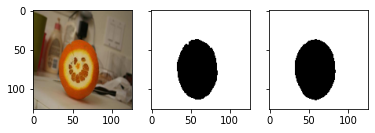

In [ ]:
#create model instance 

unet = UNET()


overfit_on_single_eg(unet,train_data,epochs=20)

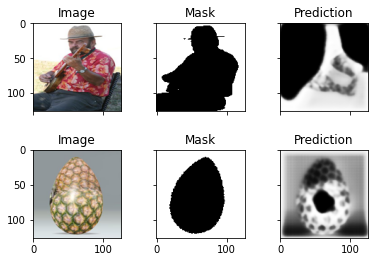

In [ ]:

visualize(unet,train_dataloader,n=2)

In [8]:
#create model instance 

unet = UNET()
model =  Seg_Model_Trainer(unet)


checkpoint_callback = [ModelCheckpoint(dirpath=root_dir,filename="unet[256]-{epoch:02d}-{val_loss:.2f}" ,save_top_k=3, monitor="val_loss",save_last=True),
                       pl.callbacks.EarlyStopping(monitor="IOU", min_delta=0.0001, patience=5, verbose=1, mode='max')]

trainer = pl.Trainer(max_epochs=50,accelerator='gpu',callbacks=checkpoint_callback)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:

trainer.fit(model,train_dataloader,val_dataloader)

Missing logger folder: /content/lightning_logs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:611: UserWarning: Checkpoint directory /content/drive/MyDrive/DigitalStudio_Assignment exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type              | Params
------------------------------------------------------
0 | DICE_loss       | DiceLoss          | 0     
1 | BCE_with_logits | BCEWithLogitsLoss | 0     
2 | model           | UNET              | 1.9 M 
3 | iou             | JaccardIndex      | 0     
------------------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.708     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric IOU improved. New best score: 0.631


Validation: 0it [00:00, ?it/s]

Metric IOU improved by 0.037 >= min_delta = 0.0001. New best score: 0.668


Validation: 0it [00:00, ?it/s]

Metric IOU improved by 0.011 >= min_delta = 0.0001. New best score: 0.679


Validation: 0it [00:00, ?it/s]

Metric IOU improved by 0.038 >= min_delta = 0.0001. New best score: 0.717


Validation: 0it [00:00, ?it/s]

Metric IOU improved by 0.031 >= min_delta = 0.0001. New best score: 0.747


Validation: 0it [00:00, ?it/s]

Metric IOU improved by 0.017 >= min_delta = 0.0001. New best score: 0.764


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric IOU improved by 0.010 >= min_delta = 0.0001. New best score: 0.774


Validation: 0it [00:00, ?it/s]

Metric IOU improved by 0.009 >= min_delta = 0.0001. New best score: 0.783


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric IOU improved by 0.008 >= min_delta = 0.0001. New best score: 0.791


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric IOU improved by 0.001 >= min_delta = 0.0001. New best score: 0.792


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric IOU improved by 0.005 >= min_delta = 0.0001. New best score: 0.798


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric IOU improved by 0.003 >= min_delta = 0.0001. New best score: 0.801


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric IOU improved by 0.001 >= min_delta = 0.0001. New best score: 0.802


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric IOU did not improve in the last 5 records. Best score: 0.802. Signaling Trainer to stop.


In [ ]:
new_model= Seg_Model_Trainer.load_from_checkpoint(checkpoint_path=f"{root_dir}/unet[256]-epoch=25-val_loss=0.22.ckpt",model=UNET())

In [ ]:
new_model

In [ ]:
trainer.validate(new_model,dataloaders=test_dataloader)   #,ckpt_path=f"{root_dir}/epoch=1-step=298-v3.ckpt")

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Accuracy            0.9293571710586548
           IOU               0.835681140422821
        val_loss            0.18355664610862732
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'Accuracy': 0.9293571710586548,
  'IOU': 0.835681140422821,
  'val_loss': 0.18355664610862732}]

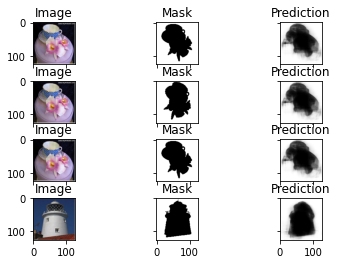

In [ ]:
visualize(new_model, test_dataloader,n=4)


** UNET WITH Attention**

In [5]:
#unet 2    
# Basic Attention mechanism applied with skip conncetion 

class ConvAttention(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self,key,query):
    score = torch.multiply(key,query)
    dk = torch.numel(score)

    weights = torch.softmax(score/dk,dim=1)

    # key = 65 x 22 x 22
    # value = 65 x 22 x 22
    #value
    context = key*weights 
    return context
class DoubleConv(nn.Module):

  def __init__(self,in_chnl,out_chnl):
    super().__init__()
    self.seq = nn.Sequential(
        nn.Conv2d(in_chnl, out_chnl, kernel_size=3,stride=1,padding=1,bias=False),
        nn.BatchNorm2d(out_chnl),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_chnl, out_chnl, kernel_size=3,stride=1,padding=1,bias=False),
        nn.BatchNorm2d(out_chnl),
        nn.ReLU(inplace=True),
    )
  def forward(self,x):
    x = self.seq(x)
    return x



class UNET_2(nn.Module):
  def __init__(self):
    super().__init__()
    in_channels=3
    out_channels=1
    channels = [16,32,64]

    self.downs = nn.ModuleList()
    self.ups = nn.ModuleList()
    for channel in channels:
      self.downs.append(DoubleConv(in_channels,channel))
      in_channels= channel
    
    for channel in reversed(channels):
      self.ups.append(nn.ConvTranspose2d(channel*2,channel,kernel_size=2,stride=2))
      self.ups.append(ConvAttention())
      self.ups.append(DoubleConv(channel*2,channel))
    
    self.maxpool = nn.MaxPool2d(kernel_size=2,stride=2)
    self.bottleneck = DoubleConv(channels[-1],channels[-1]*2)
    self.final_conv = nn.Conv2d(channels[0],out_channels,kernel_size=1)


  def forward(self,x):
    skips = []
    for down in self.downs:
      x = down(x)
      skips.append(x)
      x = self.maxpool(x)
    
    x = self.bottleneck(x)
    
    skips = skips[::-1]
    for idx in range(0,len(self.ups),3):
      x =self.ups[idx](x)
      skip_x = skips[idx//3]
      if skip_x.shape != x.shape:
        x = tvf.resize(x, size=skip_x.shape[2:])
      
      skip_x = self.ups[idx+1](skip_x,x)
      x = torch.cat((skip_x,x),dim=1)
      x = self.ups[idx+2](x)
    
    x = self.final_conv(x)
    return x

DICE loss:  0.6844672560691833,    IOU = 0.309799462556839,  Accuracy: 0.5339506268501282
DICE loss:  0.605087399482727,    IOU = 0.574999213218689,  Accuracy: 0.7305366396903992
DICE loss:  0.5212495923042297,    IOU = 0.714410662651062,  Accuracy: 0.8336482644081116
DICE loss:  0.42272651195526123,    IOU = 0.8285620212554932,  Accuracy: 0.9066515564918518
DICE loss:  0.3717222213745117,    IOU = 0.8416330814361572,  Accuracy: 0.9146510362625122
DICE loss:  0.3354136347770691,    IOU = 0.8761972188949585,  Accuracy: 0.9342403411865234
DICE loss:  0.3155438005924225,    IOU = 0.8827062845230103,  Accuracy: 0.9378306865692139
DICE loss:  0.295271635055542,    IOU = 0.8876686692237854,  Accuracy: 0.94060218334198
DICE loss:  0.2741102874279022,    IOU = 0.896196722984314,  Accuracy: 0.9453892707824707
DICE loss:  0.2565825879573822,    IOU = 0.8968449831008911,  Accuracy: 0.9457672238349915
DICE loss:  0.23890110850334167,    IOU = 0.8955941200256348,  Accuracy: 0.9450743198394775
DICE 

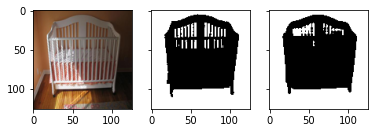

In [ ]:

unet2 = UNET_2()
model =  Seg_Model_Trainer(unet2)

overfit_on_single_eg(unet2,train_data,epochs=20)

In [ ]:

checkpoint_callback = [ModelCheckpoint(dirpath=root_dir,filename="unet[attention]-{epoch:02d}-{val_loss:.2f}" ,save_top_k=3, monitor="val_loss",save_last=True),
                       pl.callbacks.EarlyStopping(monitor="IOU", min_delta=0.0001, patience=10, verbose=1, mode='max')]

trainer = pl.Trainer(max_epochs=50,accelerator='gpu',callbacks=checkpoint_callback)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:

trainer.fit(model,train_dataloader,val_dataloader)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:611: UserWarning: Checkpoint directory /content/drive/MyDrive/DigitalStudio_Assignment exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type              | Params
------------------------------------------------------
0 | DICE_loss       | DiceLoss          | 0     
1 | BCE_with_logits | BCEWithLogitsLoss | 0     
2 | model           | UNET_2            | 482 K 
3 | iou             | JaccardIndex      | 0     
------------------------------------------------------
482 K     Trainable params
0         Non-trainable params
482 K     Total params
1.931     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric IOU improved. New best score: 0.641


Validation: 0it [00:00, ?it/s]

Metric IOU improved by 0.012 >= min_delta = 0.0001. New best score: 0.653


Validation: 0it [00:00, ?it/s]

Metric IOU improved by 0.071 >= min_delta = 0.0001. New best score: 0.724


Validation: 0it [00:00, ?it/s]

Metric IOU improved by 0.020 >= min_delta = 0.0001. New best score: 0.744


Validation: 0it [00:00, ?it/s]

Metric IOU improved by 0.003 >= min_delta = 0.0001. New best score: 0.746


Validation: 0it [00:00, ?it/s]

Metric IOU improved by 0.003 >= min_delta = 0.0001. New best score: 0.750


Validation: 0it [00:00, ?it/s]

Metric IOU improved by 0.018 >= min_delta = 0.0001. New best score: 0.767


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric IOU improved by 0.001 >= min_delta = 0.0001. New best score: 0.768


Validation: 0it [00:00, ?it/s]

Metric IOU improved by 0.001 >= min_delta = 0.0001. New best score: 0.769


Validation: 0it [00:00, ?it/s]

Metric IOU improved by 0.011 >= min_delta = 0.0001. New best score: 0.780


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric IOU improved by 0.000 >= min_delta = 0.0001. New best score: 0.781


Validation: 0it [00:00, ?it/s]

Metric IOU improved by 0.004 >= min_delta = 0.0001. New best score: 0.784


Validation: 0it [00:00, ?it/s]

Metric IOU improved by 0.006 >= min_delta = 0.0001. New best score: 0.791


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric IOU improved by 0.001 >= min_delta = 0.0001. New best score: 0.792


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric IOU improved by 0.001 >= min_delta = 0.0001. New best score: 0.793


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric IOU improved by 0.007 >= min_delta = 0.0001. New best score: 0.800


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric IOU improved by 0.004 >= min_delta = 0.0001. New best score: 0.804


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric IOU did not improve in the last 10 records. Best score: 0.804. Signaling Trainer to stop.


In [ ]:

new_model= Seg_Model_Trainer.load_from_checkpoint(checkpoint_path=f"{root_dir}/unet[attention]-epoch=37-val_loss=0.16.ckpt",model=UNET_2())
trainer.validate(new_model,dataloaders=test_dataloader)  

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Accuracy            0.9178750514984131
           IOU              0.8130093216896057
        val_loss            0.15568216145038605
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'Accuracy': 0.9178750514984131,
  'IOU': 0.8130093216896057,
  'val_loss': 0.15568216145038605}]

In [10]:
import torchvision.models as models
resnet = models.resnet18(pretrained=True)



class FCN(nn.Module):
  def __init__(self,model):
    super().__init__()
    self.model=model
    self.convT1 = nn.Sequential(nn.ConvTranspose2d(in_channels =128,out_channels=64,kernel_size = 2,stride=2,dilation=1), nn.ReLU(inplace=True))
    self.batchnorm1 = nn.BatchNorm2d(64)
    self.convT2 = nn.Sequential(nn.ConvTranspose2d(in_channels =64,out_channels=32,kernel_size = 2,stride=2,dilation=1), nn.ReLU(inplace=True))
    self.batchnorm2 = nn.BatchNorm2d(32)
    self.convT3 = nn.Sequential(nn.ConvTranspose2d(in_channels =32,out_channels=8,kernel_size = 2,stride=2,dilation=1,padding=1), nn.ReLU(inplace=True))
    self.convfinal =  nn.Sequential(nn.ConvTranspose2d(in_channels =8,out_channels=1,kernel_size = 1,stride=1,dilation=1))                        
  def forward(self,x):
    
    for module in self.model:
      x = module(x)

    x = self.convT1(x)
    x = self.batchnorm1(x)

 
    x = self.convT2(x)
    x = self.batchnorm2(x)

    x = self.convT3(x)
    
    x = self.convfinal(x)
    return x




# taking 5 of the first child layers of the resent18 

new_mod = nn.ModuleList()
layers =resnet.children()
for e,child in enumerate(layers):
  
  child.requires_grad = False
  new_mod.append(child)
  if e == 5:
    break

    

BCE loss:  0.666706919670105,    IOU = 0.39118215441703796,  Accuracy: 0.6554547548294067
BCE loss:  0.47084203362464905,    IOU = 0.6962223649024963,  Accuracy: 0.9113756418228149
BCE loss:  0.39616018533706665,    IOU = 0.839344322681427,  Accuracy: 0.9547114968299866
BCE loss:  0.34634479880332947,    IOU = 0.9149024486541748,  Accuracy: 0.9745528101921082
BCE loss:  0.33745452761650085,    IOU = 0.8727586269378662,  Accuracy: 0.9617031812667847
BCE loss:  0.3435075879096985,    IOU = 0.839515745639801,  Accuracy: 0.9487906098365784
BCE loss:  0.27006232738494873,    IOU = 0.9511440992355347,  Accuracy: 0.9862685799598694
BCE loss:  0.2632024884223938,    IOU = 0.9181737899780273,  Accuracy: 0.9769463539123535
BCE loss:  0.23083922266960144,    IOU = 0.9584232568740845,  Accuracy: 0.9882842302322388
BCE loss:  0.19999875128269196,    IOU = 0.9707406759262085,  Accuracy: 0.991748571395874
BCE loss:  0.18635959923267365,    IOU = 0.9555400609970093,  Accuracy: 0.9872134327888489
BCE l

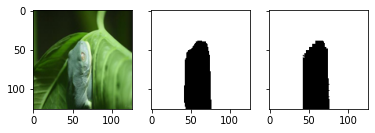

In [ ]:
fcn = FCN(new_mod)
model =  Seg_Model_Trainer(fcn)

overfit_on_single_eg(fcn,train_data,epochs=20)



In [ ]:

checkpoint_callback = [ModelCheckpoint(dirpath=root_dir,filename="fcn[resnet]-{epoch:02d}-{val_loss:.2f}" ,save_top_k=3, monitor="val_loss",save_last=True),
                       pl.callbacks.EarlyStopping(monitor="IOU", min_delta=0.0001, patience=10, verbose=1, mode='max')]

trainer = pl.Trainer(max_epochs=50,accelerator='cpu',callbacks=checkpoint_callback)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model,train_dataloader,val_dataloader)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:611: UserWarning: Checkpoint directory /content/drive/MyDrive/Dataset/Assignment exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name            | Type              | Params
------------------------------------------------------
0 | DICE_loss       | DiceLoss          | 0     
1 | BCE_with_logits | BCEWithLogitsLoss | 0     
2 | model           | FCN               | 725 K 
3 | iou             | JaccardIndex      | 0     
------------------------------------------------------
725 K     Trainable params
0         Non-trainable params
725 K     Total params
2.901     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric IOU improved. New best score: 0.708


Validation: 0it [00:00, ?it/s]

Metric IOU improved by 0.032 >= min_delta = 0.0001. New best score: 0.740


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric IOU improved by 0.006 >= min_delta = 0.0001. New best score: 0.746


Validation: 0it [00:00, ?it/s]

Metric IOU improved by 0.011 >= min_delta = 0.0001. New best score: 0.757


Validation: 0it [00:00, ?it/s]

Metric IOU improved by 0.013 >= min_delta = 0.0001. New best score: 0.770


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric IOU improved by 0.007 >= min_delta = 0.0001. New best score: 0.778


Validation: 0it [00:00, ?it/s]

Metric IOU improved by 0.001 >= min_delta = 0.0001. New best score: 0.779


Validation: 0it [00:00, ?it/s]

Metric IOU improved by 0.005 >= min_delta = 0.0001. New best score: 0.784


The Resnet + UNET arcitectuere


In [8]:
import torchvision.models as models
resnet = models.resnet18(pretrained=True)

class ResUNET(nn.Module):
  def __init__(self,model):
    super().__init__()
    self.model=model
    self.convT1 = nn.Sequential(nn.ConvTranspose2d(in_channels =128,out_channels=64,kernel_size = 2,stride=2,dilation=1), nn.ReLU(inplace=True))
    self.Dconv1 = DoubleConv(128,64)
    self.convT2 = nn.Sequential(nn.ConvTranspose2d(in_channels =64,out_channels=32,kernel_size = 2,stride=2,dilation=1), nn.ReLU(inplace=True))
    self.Dconv2 = DoubleConv(96,32)
    self.convT3 = nn.Sequential(nn.ConvTranspose2d(in_channels =32,out_channels=16,kernel_size = 2,stride=2,dilation=1,padding=1), nn.ReLU(inplace=True))
    self.Dconv3 = DoubleConv(80,16)
    self.convfinal =  nn.Sequential(nn.ConvTranspose2d(in_channels =16,out_channels=1,kernel_size = 1,stride=1,dilation=1))                        
  
  def forward(self,x):
    skips = []
    for module in self.model:
      x = module(x)

      skips.append(x)
 
    skips =skips[::-1]

    x = self.convT1(x)

    x = torch.cat((x,skips[1]),dim=1)
  
    x = self.Dconv1(x)

    x = self.convT2(x)
 
    x_s = tvf.resize(skips[3],size=x.shape[2:])

    x = torch.cat((x,x_s),dim=1)
    
    x = self.Dconv2(x)

    x = self.convT3(x)

    x_s = tvf.resize(skips[5],size=x.shape[2:])

    x = torch.cat((x,x_s),dim=1)

    x = self.Dconv3(x)
  
    x = self.convfinal(x)
    return x



new_mod = nn.ModuleList()
layers =resnet.children()
for e,child in enumerate(layers):
  
  child.requires_grad = True
  new_mod.append(child)
  if e == 5:
    break

resunet = ResUNET(new_mod) 

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

DICE loss:  1.009265422821045,    IOU = 0.22211188077926636,  Accuracy: 0.41427311301231384
DICE loss:  0.5846433043479919,    IOU = 0.38037312030792236,  Accuracy: 0.5662635564804077
DICE loss:  0.26666125655174255,    IOU = 0.9070285558700562,  Accuracy: 0.9524439573287964
DICE loss:  0.2128741443157196,    IOU = 0.9211001396179199,  Accuracy: 0.9597505927085876
DICE loss:  0.16289879381656647,    IOU = 0.944797694683075,  Accuracy: 0.9720962643623352
DICE loss:  0.1330956369638443,    IOU = 0.9647560119628906,  Accuracy: 0.9823633432388306
DICE loss:  0.13118378818035126,    IOU = 0.9632135629653931,  Accuracy: 0.9816704392433167
DICE loss:  0.11600388586521149,    IOU = 0.9665000438690186,  Accuracy: 0.9833081364631653
DICE loss:  0.10750597715377808,    IOU = 0.961985170841217,  Accuracy: 0.9809775948524475
DICE loss:  0.10075569897890091,    IOU = 0.966458797454834,  Accuracy: 0.9833081364631653
DICE loss:  0.09045927971601486,    IOU = 0.9734633564949036,  Accuracy: 0.9868354797

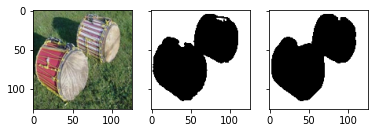

In [38]:
model =  Seg_Model_Trainer(resunet)

overfit_on_single_eg(resunet,train_data,epochs=20)

In [11]:

checkpoint_callback = [ModelCheckpoint(dirpath=root_dir,filename="ResUNET-{epoch:02d}-{val_loss:.2f}" ,save_top_k=3, monitor="val_loss",save_last=True),
                       pl.callbacks.EarlyStopping(monitor="IOU", min_delta=0.0001, patience=10, verbose=1, mode='max')]

trainer = pl.Trainer(max_epochs=50,accelerator='gpu',callbacks=checkpoint_callback)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [40]:
trainer.fit(model,train_dataloader,val_dataloader)

Missing logger folder: /content/lightning_logs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:611: UserWarning: Checkpoint directory /content/drive/MyDrive/DigitalStudio_Assignment exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type              | Params
------------------------------------------------------
0 | DICE_loss       | DiceLoss          | 0     
1 | BCE_with_logits | BCEWithLogitsLoss | 0     
2 | model           | ResUNET           | 887 K 
3 | iou             | JaccardIndex      | 0     
------------------------------------------------------
887 K     Trainable params
0         Non-trainable params
887 K     Total params
3.552     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric IOU improved. New best score: 0.711


Validation: 0it [00:00, ?it/s]

Metric IOU improved by 0.026 >= min_delta = 0.0001. New best score: 0.737


Validation: 0it [00:00, ?it/s]

Metric IOU improved by 0.015 >= min_delta = 0.0001. New best score: 0.751


Validation: 0it [00:00, ?it/s]

Metric IOU improved by 0.011 >= min_delta = 0.0001. New best score: 0.762


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric IOU improved by 0.012 >= min_delta = 0.0001. New best score: 0.774


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric IOU improved by 0.009 >= min_delta = 0.0001. New best score: 0.783


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric IOU improved by 0.009 >= min_delta = 0.0001. New best score: 0.792


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric IOU improved by 0.003 >= min_delta = 0.0001. New best score: 0.795


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric IOU improved by 0.002 >= min_delta = 0.0001. New best score: 0.797


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric IOU improved by 0.000 >= min_delta = 0.0001. New best score: 0.797


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric IOU improved by 0.001 >= min_delta = 0.0001. New best score: 0.798


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric IOU improved by 0.001 >= min_delta = 0.0001. New best score: 0.799


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric IOU improved by 0.000 >= min_delta = 0.0001. New best score: 0.799


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric IOU improved by 0.001 >= min_delta = 0.0001. New best score: 0.801


Validation: 0it [00:00, ?it/s]

Metric IOU improved by 0.002 >= min_delta = 0.0001. New best score: 0.803


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric IOU improved by 0.001 >= min_delta = 0.0001. New best score: 0.804


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [12]:
new_model= Seg_Model_Trainer.load_from_checkpoint(checkpoint_path=f"{root_dir}/ResUNET-epoch=43-val_loss=0.16.ckpt",model=resunet)
trainer.validate(new_model,dataloaders=test_dataloader) 

Missing logger folder: /content/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Accuracy            0.9236488938331604
           IOU              0.8220475912094116
        val_loss            0.1482892632484436
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'Accuracy': 0.9236488938331604,
  'IOU': 0.8220475912094116,
  'val_loss': 0.1482892632484436}]

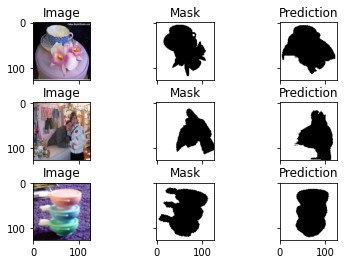

In [14]:
visualize(new_model, test_dataloader,n=3)

In [ ]:
# # checking shapes 

# min_height = 999
# min_width = 999

# max_height = 0
# max_width = 0
# min_channel = 3
# for path in tqdm(images):

#     x = torchvision.io.read_image(path)
#     min_height = min(x.shape[2],min_height)
#     min_width = min(x.shape[1],min_width)
#     max_height = max(x.shape[2],max_height)
#     max_width = max(x.shape[1],max_width)
#     min_channel = min(x.shape[0],min_channel)


# print(f"\nmin_height:  {min_height}")
# print(f"min_width:  {min_width}")
# print(f"max_height:  {max_height}")
# print(f"max_height:  {max_height}")


100%|██████████| 10551/10551 [00:35<00:00, 297.71it/s]


min_height:126
min_width:  133
max_height:  400
max_height:  400


In [ ]:
#    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])






#scripted_transforms = torch.jit.script(my_transforms)

        # # # i, j, h, w = transforms.RandomCrop.get_params(
        # # #     image, output_size=(180,180))
        # # # image = tvf.crop(image, i, j, h, w)
        # # # image = tvf.crop(image, i, j, h, w)

        # # # # Random horizontal flipping


        # # # # Random vertical flipping
        # # # if random.random() > 0.5:
        # # #     image = tvf.vflip(image)
        # # #     mask = tvf.vflip(mask)
        # # # #rotateion
        # # 
            # i, j, h, w = transforms.RandomCrop.get_params(
    #       images, output_size=(120,120)) 
    # images = tvf.crop(images, i, j, h, w)
    # masks = tvf.crop(masks, i, j, h, w)